## Imports and matplotlib config

Also sets rng seed for reproducible research

In [1]:
%pylab inline
figsize(10,10) # in the global namespace when inline backend is in use.

Populating the interactive namespace from numpy and matplotlib


In [2]:
import importlib
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx
import numpy as np
import numpy.random as npr
import numpy.linalg as npl
import pickle
import scipy.stats as sps
import seaborn as sns
import seaborn.distributions as snsd


from algorithms.confidence_ss import confidenceMCMC 
from algorithms.confidence_ss import confidenceMCMCWithProxy
from algorithms.confidence_ss import confidenceMCMCWithProxyDroppedAlong
from algorithms.iss import iss_mcmc
from algorithms.utils import chain_error
from algorithms.vanillaMH import vanillaMH

In [3]:
sns.set(style="ticks");

plt.ioff() # turn off interactive plotting
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
mpl.rcParams['xtick.labelsize'] = 22
mpl.rcParams['ytick.labelsize'] = 22
mpl.rcParams['axes.titlesize'] = 22
plt.rc('axes', labelsize=22)
plt.rc('legend', fontsize=22)
mpl.rcParams['ps.useafm'] = True
mpl.rcParams['pdf.use14corefonts'] = True
mpl.rcParams['text.usetex'] = True
saveDirStr = "scaling_figs"
npr.seed(1)

# Smallest and largest exponents of 10 we test for sample size
small_exp = 3
large_exp = 6
exp_step= 0.5

EXPERIMENT_MAX_CHAIN_LENGTH = int(10**6)
REFERENCE_CHAIN_LENGTH = int(100*10**3)
EXPERIMENT_TIME_BUDGET = 60*5 # 5mins

# Scaling Experiment

### Generate parent sample
### Generate references across experiments using VanillaMH

In [4]:
try:
    print('Trying to load existing references')
    ref_chains = pickle.load(open('ref_chains.p', 'rb'))
    print('refchains loaded')
    experiment_samples = pickle.load(open('experiment_samples.p', 'rb'))
    print('samples loaded')
    experiment_MLEs = pickle.load(open('experiment_MLEs.p', 'rb'))
    print('MLEs loaded')
    sample_sizes_tested = [len(sample) for sample in experiment_samples]
    print(f'Testing N in {sample_sizes_tested}')
except FileNotFoundError:
    print('Cannot fine one or more existing references - regenerating.')
    sample_sizes_tested = [int(10**exp) for exp in np.arange(small_exp,large_exp+exp_step,exp_step)]
    max_samples = int(10**large_exp)
    # Here is where we make the model mis-specified if we wish to
    dataType = "Gaussian"
    if dataType == "Gaussian":
        parent_x = npr.randn(max_samples)
    elif dataType == "logNormal":
        parent_x = npr.lognormal(0,1,size=max_samples)
    elif dataType == "laplace":
        parent_x = npr.laplace(0,math.pow(0.5,0.5),size=max_samples)

    ref_chains = list()
    experiment_samples = list()
    experiment_MLEs = list()

    for i in sample_sizes_tested:
        # Watch out - python list and numpy array have append mean smth different
        experiment_samples.append(parent_x[:int(i)])

    for i, x in enumerate(experiment_samples):
        print(f'Generating reference with {sample_sizes_tested[i]:.2E} samples')
        realMean = np.mean(x)
        realStd = np.std(x)
        initial_theta = np.array([realMean,np.log(realStd)])
        experiment_MLEs.append(initial_theta)
        ref_chains.append(vanillaMH(initial_theta,x,time_budget=np.inf,chain_length=REFERENCE_CHAIN_LENGTH)[0])

    # To avoid losing these if we clear the notebook, pickle em
    print('Saving pickles to avoid having to recompute')
    pickle.dump(ref_chains,open('ref_chains.p', 'wb'))
    print('refchains saved')
    pickle.dump(experiment_samples,open('experiment_samples.p', 'wb'))
    print('experiment_samples saved')
    pickle.dump(experiment_MLEs,open('experiment_MLEs.p', 'wb'))
    print('experiment_MLEs saved')

Trying to load existing references
Cannot fine one or more existing references - regenerating.
Generating reference with 1.00E+02 samples
Iteration 0 Acceptance 1.0
Iteration 5000 Acceptance 0.5000999800039992
Iteration 10000 Acceptance 0.5088491150884912
Iteration 15000 Acceptance 0.5086994200386641
Iteration 20000 Acceptance 0.5103244837758112
Iteration 25000 Acceptance 0.5126594936202552
Iteration 30000 Acceptance 0.5139495350154994
Iteration 35000 Acceptance 0.515528127767778
Iteration 40000 Acceptance 0.5157621059473513
Iteration 45000 Acceptance 0.5157218728472701
Generating reference with 3.16E+02 samples
Iteration 0 Acceptance 1.0
Iteration 5000 Acceptance 0.500499900019996
Iteration 10000 Acceptance 0.5047495250474953
Iteration 15000 Acceptance 0.5080994600359976
Iteration 20000 Acceptance 0.5077746112694366
Iteration 25000 Acceptance 0.5062597496100156
Iteration 30000 Acceptance 0.5045165161161295
Iteration 35000 Acceptance 0.5043284477586355
Iteration 40000 Acceptance 0.5038

### Run experiments for varying N across all algorithms of interest

In [5]:
# Sanity check of alg working
mh_results = vanillaMH(experiment_MLEs[0],experiment_samples[0])

Iteration 0 Acceptance 1.0
Iteration 1000 Acceptance 0.4985014985014985
Iteration 2000 Acceptance 0.5052473763118441
Iteration 3000 Acceptance 0.509830056647784
Iteration 4000 Acceptance 0.5131217195701074
Iteration 5000 Acceptance 0.5140971805638872
Iteration 6000 Acceptance 0.5060823196133978
Iteration 7000 Acceptance 0.5047850307098986
Iteration 8000 Acceptance 0.50368703912011
Iteration 9000 Acceptance 0.5059437840239973


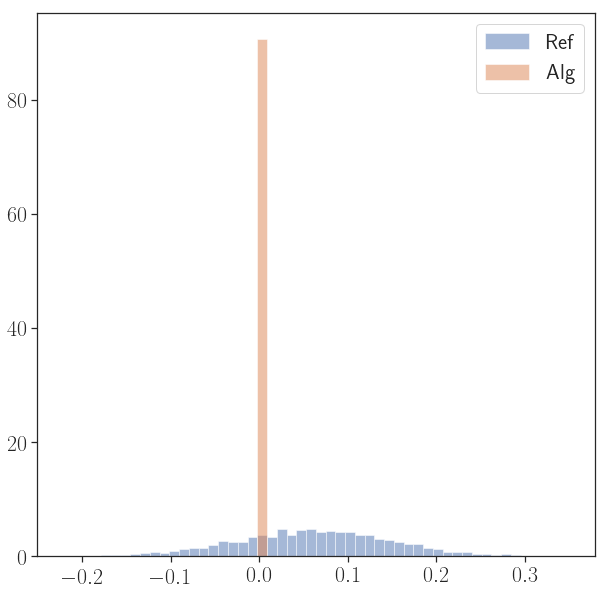

1.9159999999999995

In [6]:
# Sanity check that error function is working as expected
chain_error(mh_results[0][:,0],np.array([0]*9999),show_hists=True,bins=10)

In [7]:
def run_experiment(algorithm):
    mean_errors = []
    std_errors = []
    alg_steps_taken = []
    show_hists = False
    for i, x in enumerate(experiment_samples):
        ref_chain = ref_chains[i]
        print(f'Running experiment with N = {sample_sizes_tested[i]:.2E}, time budget {EXPERIMENT_TIME_BUDGET}, max chain length {EXPERIMENT_MAX_CHAIN_LENGTH}')
        initial_theta = experiment_MLEs[i]
        chain, _ , chain_steps_taken = algorithm(initial_theta, x, time_budget=EXPERIMENT_TIME_BUDGET, chain_length=EXPERIMENT_MAX_CHAIN_LENGTH)
        # I just wanna see the last histograms
        if i == len(experiment_samples)-1:
            show_hists = True
        # Think about using jsut one reference chain?
        mean_errors.append(chain_error(ref_chain[:,0],chain[:,0],show_hists=show_hists, title=f"Mean \n Ref Samples = {len(ref_chain[:,0])}, Alg Samples = {len(chain[:,0])}"))
        std_errors.append(chain_error(ref_chain[:,1],chain[:,1],show_hists=show_hists, title=f"log(Std) \n Ref Samples = {len(ref_chain[:,0])}, Alg Samples = {len(chain[:,0])}"))
        alg_steps_taken.append(chain_steps_taken)
    return (mean_errors, std_errors, alg_steps_taken)


Running experiment with N = 1.00E+02, time budget 5, max chain length 1000000
Iteration 0 Acceptance 1.0
Time budget consumed at chain step 70001, returning truncated result
Running experiment with N = 3.16E+02, time budget 5, max chain length 1000000
Iteration 0 Acceptance 1.0
Time budget consumed at chain step 73774, returning truncated result
Running experiment with N = 1.00E+03, time budget 5, max chain length 1000000
Iteration 0 Acceptance 1.0
Time budget consumed at chain step 62498, returning truncated result
Running experiment with N = 3.16E+03, time budget 5, max chain length 1000000
Iteration 0 Acceptance 1.0
Time budget consumed at chain step 44573, returning truncated result
Running experiment with N = 1.00E+04, time budget 5, max chain length 1000000
Iteration 0 Acceptance 0.0
Time budget consumed at chain step 25594, returning truncated result


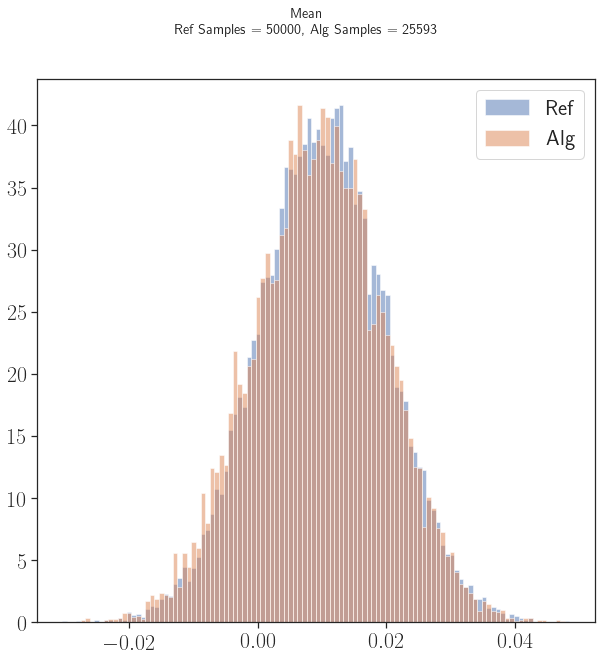

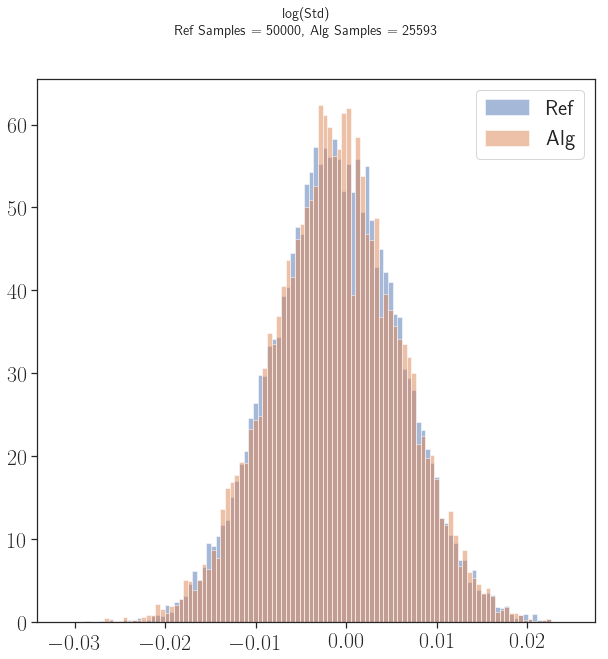

In [8]:
mh_results = run_experiment(vanillaMH)
pickle.dump(mh_results,open('mh_results.p', 'wb'))
print('mh_results saved')

Running experiment with N = 1.00E+02, time budget 5, max chain length 1000000
Running ISS with n = 10, k = 3
Iteration 0 Theta Acceptance 0.0 Sample Acceptance 0.0
Time budget consumed at chain step 30857, returning truncated result
Running experiment with N = 3.16E+02, time budget 5, max chain length 1000000
Running ISS with n = 17, k = 4
Iteration 0 Theta Acceptance 1.0 Sample Acceptance 0.0
Time budget consumed at chain step 27138, returning truncated result
Running experiment with N = 1.00E+03, time budget 5, max chain length 1000000
Running ISS with n = 31, k = 5
Iteration 0 Theta Acceptance 1.0 Sample Acceptance 0.0
Time budget consumed at chain step 21014, returning truncated result
Running experiment with N = 3.16E+03, time budget 5, max chain length 1000000
Running ISS with n = 56, k = 7
Iteration 0 Theta Acceptance 1.0 Sample Acceptance 0.0
Time budget consumed at chain step 11415, returning truncated result
Running experiment with N = 1.00E+04, time budget 5, max chain lengt

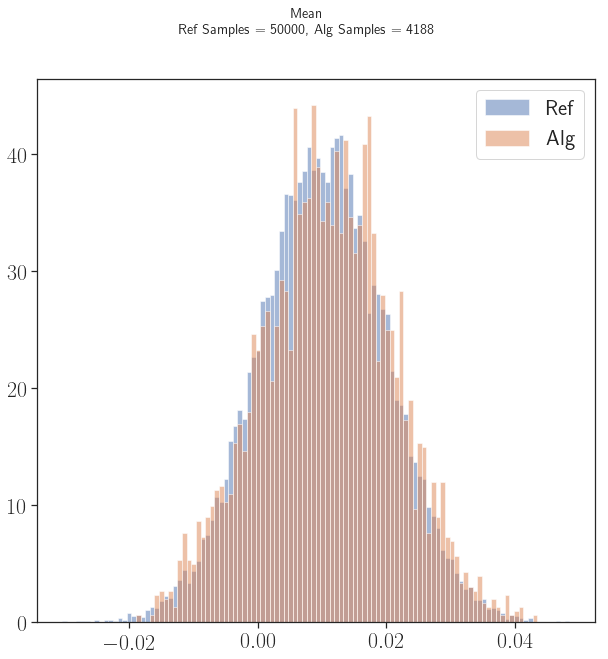

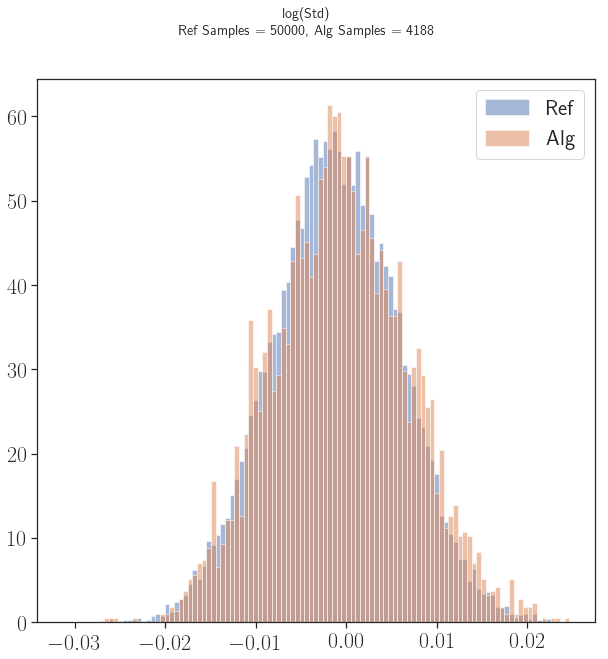

In [9]:
iss_results = run_experiment(iss_mcmc)
pickle.dump(iss_results,open('iss_results.p', 'wb'))
print('iss_results saved')

Running experiment with N = 1.00E+02, time budget 5, max chain length 1000000
Iteration 0 Acceptance 1.0 Avg. num evals 146.0 sigma/sqrt(n) 0.0010200258008948378 R/n 0.000551020988982107
Time budget consumed at chain step 7173, returning truncated result
Running experiment with N = 3.16E+02, time budget 5, max chain length 1000000
Iteration 0 Acceptance 1.0 Avg. num evals 632.0 sigma/sqrt(n) 0.0018244341991955275 R/n 0.0006938236953451516
Time budget consumed at chain step 6826, returning truncated result
Running experiment with N = 1.00E+03, time budget 5, max chain length 1000000
Iteration 0 Acceptance 1.0 Avg. num evals 2000.0 sigma/sqrt(n) 0.00026970324352802917 R/n 9.827049502304506e-05
Time budget consumed at chain step 6261, returning truncated result
Running experiment with N = 3.16E+03, time budget 5, max chain length 1000000
Iteration 0 Acceptance 1.0 Avg. num evals 6324.0 sigma/sqrt(n) 0.0003682105698064193 R/n 7.519605543828721e-05
Time budget consumed at chain step 4947, r

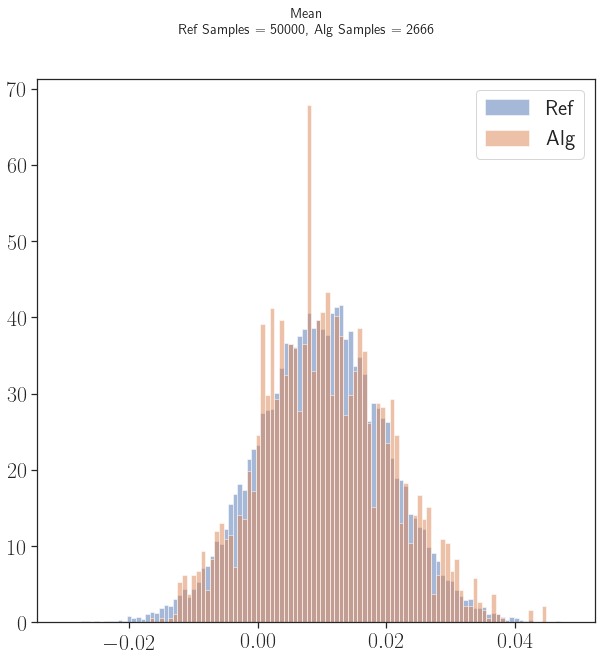

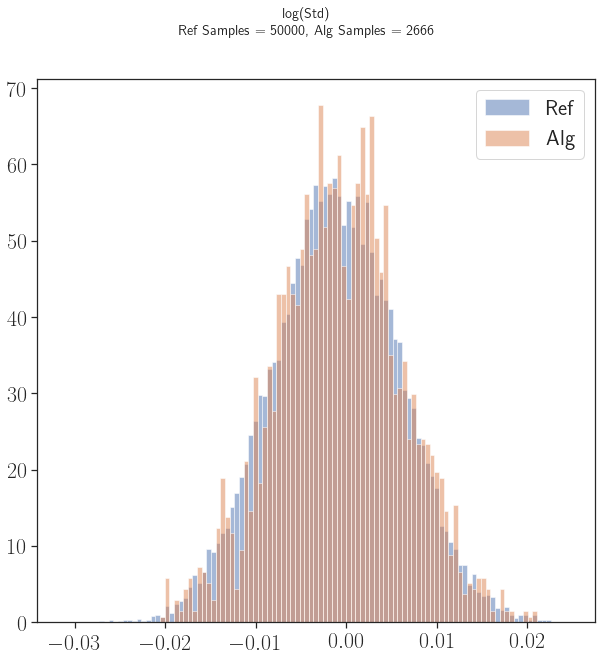

In [10]:
# cs_results = run_experiment(confidenceMCMC)

Running experiment with N = 1.00E+02, time budget 5, max chain length 1000000
MAP is [0.00596017 0.01813638] Real values are 0.060582852075698704 -0.12199113674670868
[2*(-1 + 6*(mu - x)**2/sigma**2)/sigma**3, -6*(mu - x)/sigma**4, 2/sigma**3, 0]
Iteration 0 Acceptance 1.0 Avg. num samples 200.0 Dist. to MAP 0.10403256633989658 sigma/sqrt(n) 0.0008298637147191237 R/n 0.005564457579352714
Time budget consumed at chain step 283, returning truncated result
Running experiment with N = 3.16E+02, time budget 5, max chain length 1000000
MAP is [0.01451842 0.00892436] Real values are 0.08829049005275078 -0.039710376153531866
[2*(-1 + 6*(mu - x)**2/sigma**2)/sigma**3, -6*(mu - x)/sigma**4, 2/sigma**3, 0]
Iteration 0 Acceptance 0.0 Avg. num samples 632.0 Dist. to MAP 0.12240681104829886 sigma/sqrt(n) 0.002070833626440061 R/n 0.009129237734170376
Time budget consumed at chain step 283, returning truncated result
Running experiment with N = 1.00E+03, time budget 5, max chain length 1000000
MAP is 

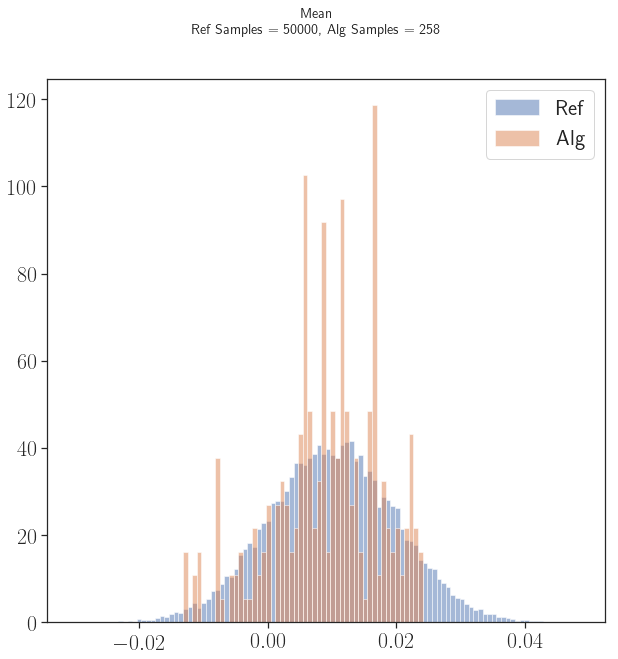

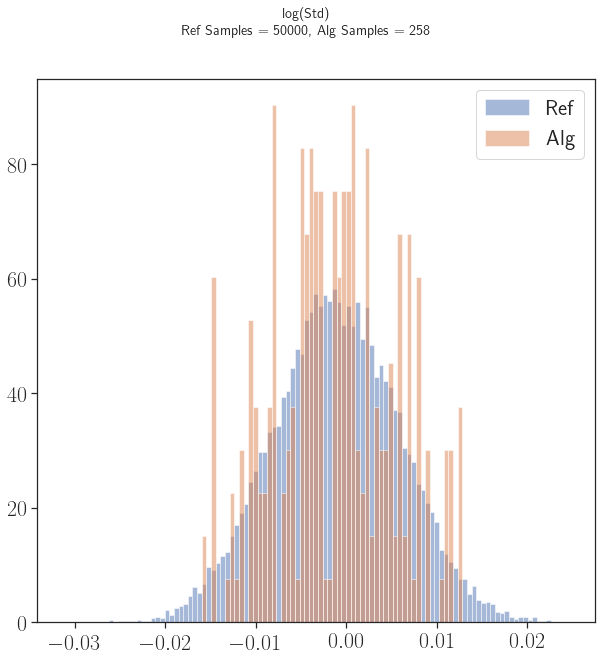

In [11]:
ics_results = run_experiment(confidenceMCMCWithProxy)
pickle.dump(ics_results,open('ics_results.p', 'wb'))
print('ics_results saved')

Running experiment with N = 1.00E+02, time budget 5, max chain length 1000000
Iteration 0 Acceptance 1.0 Avg. num samples 200.0 Dist. to MAP 0.03191078660716151 sigma/sqrt(n) 0.0001821895418032564 R/n 0.0006915052526866186
Time budget consumed at chain step 342, returning truncated result
Running experiment with N = 3.16E+02, time budget 5, max chain length 1000000
Iteration 0 Acceptance 0.0 Avg. num samples 632.0 Dist. to MAP 0.09168508683329825 sigma/sqrt(n) 0.0003032986032060791 R/n 0.00046903125553521795
Time budget consumed at chain step 323, returning truncated result
Running experiment with N = 1.00E+03, time budget 5, max chain length 1000000
Iteration 0 Acceptance 0.0 Avg. num samples 2000.0 Dist. to MAP 0.028912963351799378 sigma/sqrt(n) 0.00016640007425729666 R/n 0.0011665591117615013
Time budget consumed at chain step 353, returning truncated result
Running experiment with N = 3.16E+03, time budget 5, max chain length 1000000
Iteration 0 Acceptance 0.0 Avg. num samples 6324

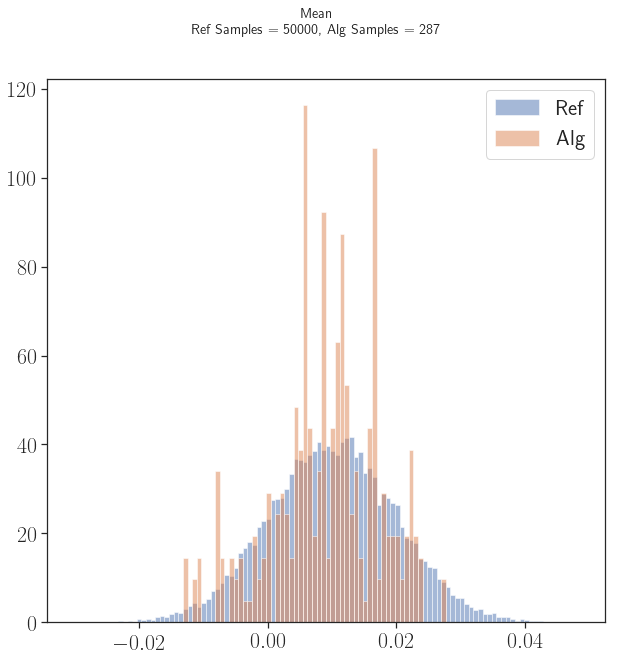

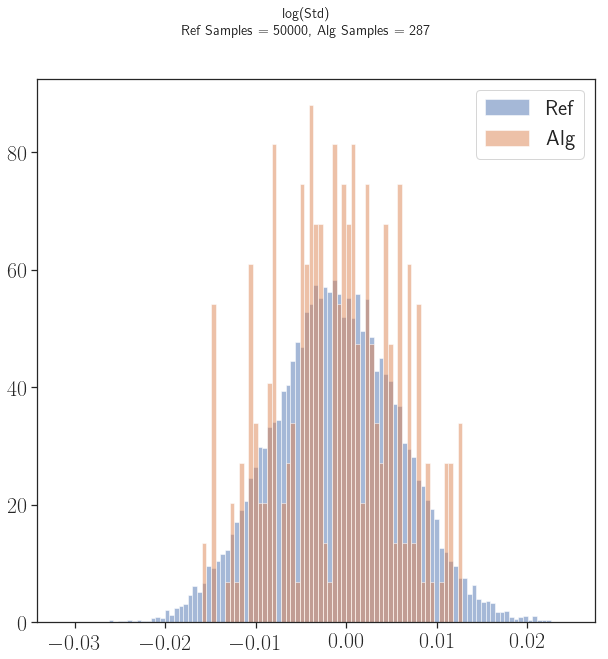

In [12]:
# ics_w_drop = run_experiment(confidenceMCMCWithProxyDroppedAlong)

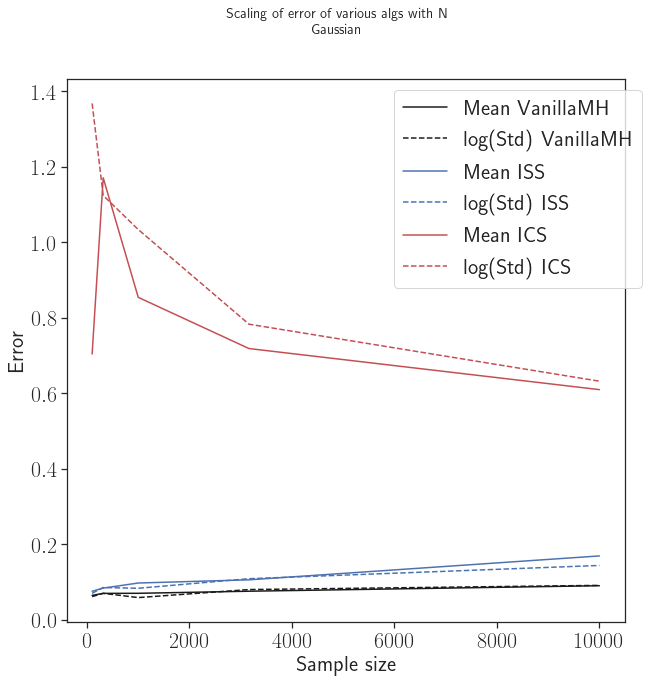

In [13]:
plt.clf()
plt.plot(
    sample_sizes_tested, mh_results[0], 'k',
    sample_sizes_tested, mh_results[1], '--k',
    sample_sizes_tested,iss_results[0], 'b',
    sample_sizes_tested,iss_results[1], '--b',
    sample_sizes_tested,ics_results[0], 'r',
    sample_sizes_tested,ics_results[1], '--r'
)
plt.suptitle(f'Scaling of error of various algs with N \n {dataType}')
plt.xlabel(f'Sample size')
plt.ylabel(f'Error')
plt.legend(('Mean VanillaMH', 
            'log(Std) VanillaMH',
            'Mean ISS',
            'log(Std) ISS',
            'Mean ICS',
            'log(Std) ICS'),
        bbox_to_anchor=(1.05, 1))
plt.show()

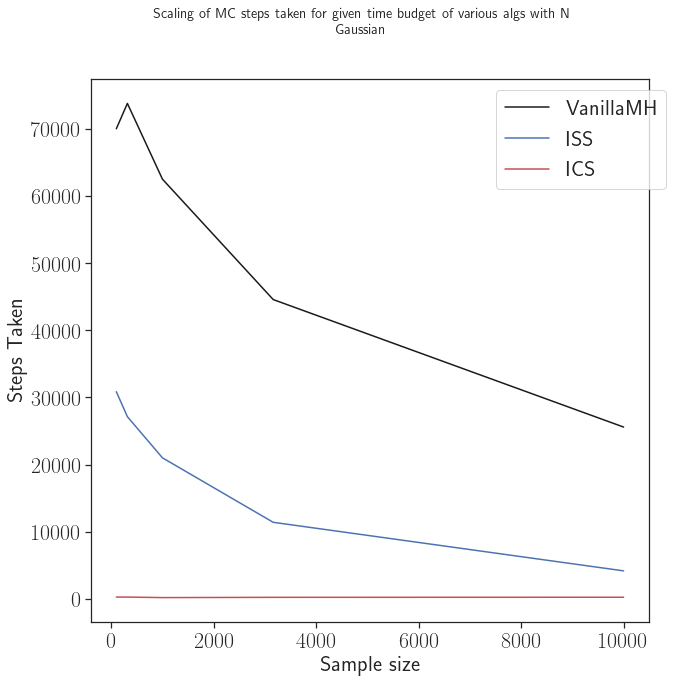

In [14]:
plt.clf()
plt.plot(
    sample_sizes_tested, mh_results[2], 'k',
    sample_sizes_tested,iss_results[2], 'b',
    sample_sizes_tested,ics_results[2], 'r',
)
plt.suptitle(f'Scaling of MC steps taken for given time budget of various algs with N \n {dataType}')
plt.xlabel(f'Sample size')
plt.ylabel(f'Steps Taken')
plt.legend(('VanillaMH', 
            'ISS',
            'ICS'),
        bbox_to_anchor=(1.05, 1))
plt.show()

# Critique: starting in MLE where we know mode already is